In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow[and-cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 17.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 26.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 73.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 50.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 767.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━

In [1]:
pip install librosa

     |████████████████████████████████| 253 kB 4.1 MB/s            
     |████████████████████████████████| 1.2 MB 41.8 MB/s            
     |████████████████████████████████| 1.2 MB 39.6 MB/s            
     |████████████████████████████████| 60 kB 7.4 MB/s             
     |████████████████████████████████| 530 kB 70.3 MB/s            
     |████████████████████████████████| 3.6 MB 44.6 MB/s            
     |████████████████████████████████| 43.6 MB 77.6 MB/s            
     |████████████████████████████████| 18.3 MB 65.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.0
    Uninstalling typing-extensions-4.0.0:
      Successfully uninstalled typing-extensions-4.0.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --update pip


Usage:   
  /opt/conda/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/conda/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/conda/bin/python -m pip install [options] [-e] <vcs project url> ...
  /opt/conda/bin/python -m pip install [options] [-e] <local project path> ...
  /opt/conda/bin/python -m pip install [options] <archive url/path> ...

no such option: --update
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


# I. Creation of the database (training, test, evaluation dataset):

In [1]:
import pandas as pd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import keras

2023-10-17 14:04:01.820025: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 14:04:01.820071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 14:04:01.820104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 14:04:01.828189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## A. Gathering signals data:

In [2]:
path_audio_folder = "./data/clean_audio"
list_audio_clean = os.listdir(path_audio_folder)
files_paths = [path_audio_folder + "/" + list_audio_clean[i] for i in range(len(list_audio_clean))]

In [5]:
signal_test_0 = sf.read(files_paths[0])[0]
signal_test_1 = sf.read(files_paths[1])[0]

## B. Creating noisy signals

In [6]:
path_noise_file = "./data/babble_16k.wav"
noise,samplerate = sf.read(path_noise_file)

In [7]:
noisy_signal_0 = signal_test_0 + noise[:len(signal_test_0)]
noisy_signal_1 = signal_test_1 + noise[:len(signal_test_1)]

# II. Implementation of the training 

In [8]:
import librosa

In [9]:
def display_spectogramm(signal):
    signal_stft_abs = np.abs(signal)**2
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(signal_stft_abs,ref=np.max),y_axis='log', x_axis='time', ax=ax)
    ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [10]:
# First we made the STFT of the signal
signal_stft_test_0 = librosa.stft(signal_test_0)
signal_stft_test_1 = librosa.stft(signal_test_1)
noisy_signal_stft_0 = librosa.stft(noisy_signal_0)
noisy_signal_stft_1 = librosa.stft(noisy_signal_1)

In [11]:
# Creation of the mask. if /s/^2 > /u/^2 M = 1, 0 otherwise
signal_abs = np.abs(signal_stft_test_0)**1
noise_abs = np.abs(noisy_signal_stft_0)**1
mask = np.zeros(np.shape(signal_abs))
test = 0
for i in range (np.shape(signal_abs)[0]):
    for j in range(np.shape(signal_abs)[1]):
        if (signal_abs[i,j] > noise_abs[i,j]):
            test+=1
            mask[i,j] = 1
print(test)

10369


In [12]:
test = signal_abs - mask

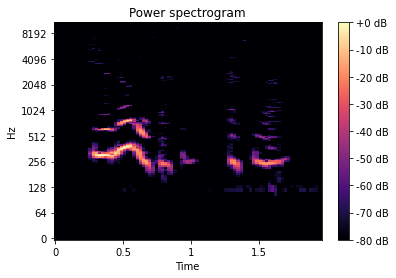

In [13]:
display_spectogramm(test)

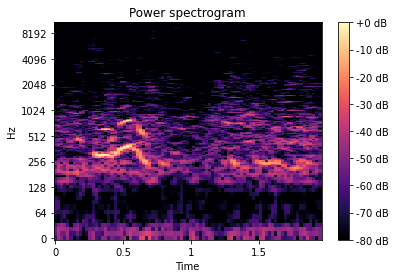

In [14]:
display_spectogramm(noise_abs)

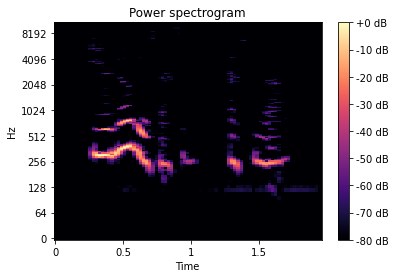

In [15]:
display_spectogramm(signal_abs)

In [ ]:
# test concluant, il faut maintenant mettre en place une fonction de coût!
Ensuite mettre en place les datasets 
enfin créer une première architecture de réseau de neurones. 